<a href="https://colab.research.google.com/github/thierrytheg/shared_colab/blob/main/accounting_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detect Outliers in your General Ledger**

This tool allows accounting professionals to vizualize their General Ledger in an intuitive format while getting instantaneous feedback on which transactions have been flagged as anomalies and require further investigation.

---

The is a free, dynamic and fully customizable tool that is the answer to a lack of free products available for helping accounting professionals implement and enforce internal controls procedures.

I hope you find it useful as much as I have and I look forward to your feedback and suggestions for improvement.





#How to start

Click Run All under the Rutime tab and press Ctrl+F9.
The script should not take more than 1 minute to run from start to finish.

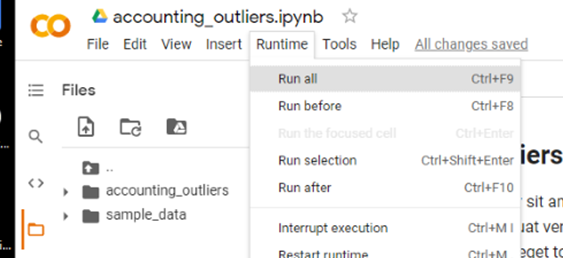

**How to create your own reports**

Once you have become familiarized with the notebook, feel free to add your own dataset and edit the code to suit your needs. To do so, please follow the instructions below.

If you are using any of the software listed below, follow the link to learn how to collect the data you will need to create your own report

*   **Sage**
The information you will need is located in table *tJEntAct*. 

*   **Quickbooks**
The data dictionary is available [here](https://qbar.intuit.com/resources.html). The information you will need is located in the *transaction* table. 

*   **Xero**
does not allow direct access to its database, but you can access the data you need through the [API](https://developer.xero.com/documentation/api/journals). 


Once you have created your csv or Excel file, you must:

1.   Delete any existing csv or Excel files in the following folder
  /accounting_outliers/uploads/
2.   Upload your file
3.   Run the notebook starting at step 2 by clicking the play  button.<table class="tfo-notebook-buttons" align="left">
  <td>

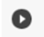
  </td>

</table>


## Step 1: Environment Setup

In this section, we clone the github repository that contains the sample dataset and install the dependencies.



###Clone Github Repository

In [25]:
!git clone https://github.com/thierrytheg/accounting_outliers.git

Cloning into 'accounting_outliers'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 66 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (66/66), done.


###Install Dependencies

In [26]:
!pip install flask-ngrok==0.0.25
!pip install pandas==1.1.5
!pip install openpyxl==2.5.9
!pip install matplotlib.pyplot==3.2.2
!pip install numpy==1.19.5
!pip install ipywidgets==7.6.3

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot==3.2.2 (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot==3.2.2


##Step 2: Dataset


### Ensure dataset is in the correct folder and has valid format

In [32]:
import pandas as pd

import os
os.chdir(r'/content/accounting_outliers/uploads/')
 
try:
 
  if len([name for name in os.listdir('.') if (os.path.isfile(name) and ((name.split('.')[1]).startswith('xls') or (name.split('.')[1]).startswith('csv')))])==0:
    print("You have no files in the uplodad folder.")
 
  elif len([name for name in os.listdir('.') if (os.path.isfile(name) and ((name.split('.')[1]).startswith('xls') or (name.split('.')[1]).startswith('csv')))])>1:
    print("You have too many files in the uplodad folder. Please remove %s files in order to keep 1." %len([name for name in os.listdir('.') if (os.path.isfile(name) and ((name.split('.')[1]).startswith('xls') or (name.split('.')[1]).startswith('csv'))-1)])) 
 
  elif len([name for name in os.listdir('.') if (os.path.isfile(name) and ((name.split('.')[1]).startswith('xls') or (name.split('.')[1]).startswith('csv')))])==1:
    for file in os.listdir(os.getcwd()):
      if os.path.isfile(file) and (file.split('.')[1]).startswith('xls'):
 
        try:
          if file.split('.')[1]=='csv':
            df=pd.read_csv(file)
 
 
          elif (file.split('.')[1]).startswith('xls'):
            df=pd.read_excel(file)
 
            print("Your dataset contains %s columns and %s rows for a total of %s elements." %(df.shape[1],df.shape[0],df.size))
 
          else:
            print("The file is not an excel or a csv")
 
 
        except Exception as e:
          print(files,e)
 
except Exception as e:
  print(e)

Your dataset contains 3 columns and 3054 rows for a total of 9162 elements.


### Identify required features such as the Amount and GL Account.
If the file you have uploaded is missing the 'Account' or 'Amount' columns or if the headers need to be changed, you will be prompted to make the necessary changes and upload a revised file.


In [33]:
#Detect column with Account Listing
 
for n in range(len(df.columns)):
  if ('acc' or 'account') in (df.columns[n]).lower():
    df['Account']=df[df.columns[n]]
    print("An 'Account' column was successfully identified")
    
 
#Detect column with dollar values
for n in range(len(df.columns)):
  if ('am' or 'amount') in (df.columns[n]).lower():
    df['Amount']=df[df.columns[n]]
    print("An 'Amount' column was successfully identified")
    
 
new_columns=['Account','Amount']
for column in new_columns:
  if column in df.columns:
    pass
  else:
    print("Unable to detect your %s column. Please rename the appropriate column '%s' and re-upload the file" %(column,column))

An 'Account' column was successfully identified
An 'Amount' column was successfully identified


## Step 3: Plot Benford's Distribution

### What is Benford's Law and how to interpret it

Benford's Law maintains that the numeral 1 will be the leading digit in a genuine data set of numbers 30.1% of the time; the numeral 2 will be the leading digit 17.6% of the time; and each subsequent numeral, 3 through 9, will be the leading digit with decreasing frequency.

This expected occurrence of leading digits follow Benford curve (see blue bars in histogram below). 

Based on the assumption that people who fabricate figures tend to distribute their digits fairly uniformly, a simple comparison of first-digit frequency distribution from the data with the expected distribution according to Benford's law ought to show up any anomalous results.



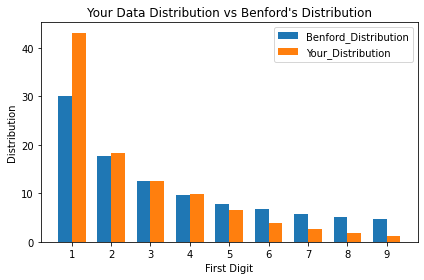

In [34]:
#Detect time series to use for calculations convert Amount to absolute values
 
try:
  df['Abs_Val']=abs(df['Amount'])
 
  #filter out all rows with values under 1
  df=df.loc[df['Abs_Val']>1]
 
  #convert First_Digit column to string and extract first digit
  df['First_Digit']=(df['Abs_Val']).apply(str).str[0]
 
  #create series with count for each first digit
  benford_df=df['First_Digit'].value_counts()
  benford_df['Your_Dist_Pct']=round((benford_df/benford_df.sum())*100,1)
 
 
  #create a temporary dataframe to plot Benford Distribution
  benford_list=(benford_df['Your_Dist_Pct']).to_list()
 
  data={
  'First_Digit':[1,2,3,4,5,6,7,8,9],
  'Your_Distribution' : benford_list,
  'Benford_Distribution': [30.1,17.6,12.5,9.7,7.9,6.7,5.8,5.1,4.6]
  }
  df_plot=pd.DataFrame(data=data,columns=['First_Digit','Your_Distribution','Benford_Distribution'])
  #df_plot
 
except Exception as e:
  print(e)
 
 
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
 
import matplotlib.pyplot as plt
import numpy as np
 
labels = df_plot['First_Digit']

Benford_Distribution = list(df_plot['Benford_Distribution'])
Your_Distribution = list(df_plot['Your_Distribution'])
 
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
 
fig, ax = plt.subplots()
 
rects1 = ax.bar(x - width/2, Benford_Distribution, width, label='Benford_Distribution')
rects2 = ax.bar(x + width/2, Your_Distribution, width, label='Your_Distribution')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('First Digit')
ax.set_ylabel('Distribution')
 
ax.set_title("Your Data Distribution vs Benford's Distribution")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
 
 
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(''.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
 
 
autolabel(rects1)
autolabel(rects2)
 
fig.tight_layout()
 
plt.show()
a=fig.savefig(r'/content/accounting_outliers/uploads/benford_dtr.png')

If your data (in orange) follows Benford's Distribution (in blue), your general ledger is likely free of fraudulent transactions. On the other hand, if your data distribution drastically diverges from Benford's distribution, your general ledger is likely to contain erroneous or fraudulent transactions that need to be investigated and might result in changes in internal control procedures.

You can download he chart above by clicking on the folder icon as shown below.

---
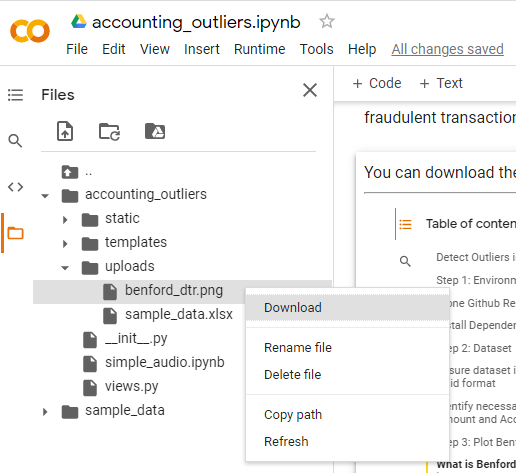

##Step 4: Detect Outliers

#### BoxPlots

Boxplots are a suitable tool for this purpose as they allow us to vizualize data distribution as well as the median and the quantile distribution in one single visual.



#### Plot Accounting Data Distribution

In [63]:
#Vizualize your data by account and immediately identify outliers
 
import altair as alt
import ipywidgets as widgets
 
q3_sensitivity=0.75
q1_sensitivity=0.25
 
 
account_picker = widgets.SelectMultiple(
    options=sorted(df.Account.unique()),
    value=list(df.Account.unique()),
    description='GL Account')
 
@widgets.interact(account=account_picker)
def render(account):
  selected = df[df.Account.isin(list(account))]
  print("==============")
 
  outlierq3=(selected[selected.columns].loc[selected['Amount']>(np.quantile(selected['Amount'],q3_sensitivity))])
  outlierq1=(selected[selected.columns].loc[selected['Amount']<(np.quantile(selected['Amount'],q1_sensitivity))])
 
 
  quant=[]
  quant.append([abs(np.quantile(selected['Amount'],q3_sensitivity)),abs(np.quantile(selected['Amount'],q1_sensitivity))])

  if (len(outlierq1) and len(outlierq3)) == 0:
    print("No outliers were detected for this account")
 
 
  else:
 
    print("Outliers detected for this account: %s" %((outlierq3.shape[0])+outlierq1.shape[0]))    
 
    print("For the account(s) selected,")
    print("Transactions smaller than %s and greater than %s, require special attention." %("{:,.2f}".format(abs(min(quant[0]))),"{:,.2f}".format(abs(max(quant[0])))))
    return alt.Chart(selected).mark_boxplot().encode(
      y='Amount',).properties(width=300,height=500)

interactive(children=(SelectMultiple(description='GL Account', index=(0, 74, 70, 68, 69, 73, 72, 71, 48, 80, 7…

alt.Chart(...)

alt.Chart(...)

#Conclusion

By integrating the above code with flask or jupyter-dash, you can turn this project into a tool with a friendy user interface that can easily be distributed and used across platforms.

I hope you find it useful as much as I have and I look forward to your feedback and suggestions for improvement.